In [1]:
from dataclasses import dataclass, field
from typing import List, Set, Tuple, Any, Dict, DefaultDict, Optional, Callable, cast
import copy
import uuid
from collections import defaultdict
from itertools import permutations
import matplotlib.pyplot as plt
import random
import math

In [2]:
class Call:
    def __init__(self, threadno, func, args, start, end):
        super().__init__()
        self.threadno : int = threadno
        self.func : str = func
        self.args : List[Any] = args
        self.start : int = start
        self.end : int = end
        self.order : Optional[int] = None

    def __eq__(self, other : 'Call'):
        return (self.threadno, self.func, self.args, self.start, self.end, self.order) == (other.threadno, other.func, other.args, other.start, other.end, other.order)

    def __repr__(self):
        return f'Call({self.threadno}, {self.func}, {self.args}, {self.start}, {self.end})'
    
    def __str__(self):
        return f'{self.func}({self.args})'
    
    def exec(self) -> Tuple['State', Any]:
        raise NotImplementedError

class State:
    def copy(self) -> 'State':
        raise NotImplementedError
    

class History:
    """Nice wrapper for a list of calls"""
    def __init__(self, calls : List[Call]):
        self.calls : List[Call] = calls
    
    def __eq__(self, other : 'History'):
        return self.calls == other.calls


In [3]:
def sort_by_thread(spec: List[Call]):
    threads : DefaultDict[int, List[Call]] = defaultdict(list)
    for c in spec:
        threads[c.threadno].append(c)
    return threads

def visualize_history(spec : List[Call]):
    # make the graph big enough so that the labels don't overlap
    fig, ax = plt.subplots(figsize=(16, 10))
    threads = sort_by_thread(spec)

    ax.set_yticks(range(max(threads.keys()) + 2))
    # leave margins on the top and bottom of the graph for the labels
    ax.set_ylim(-0.5, max(threads.keys()) + 1.5)

    for threadno, ops in threads.items():
        for op in ops:
            # draw the interval
            ax.plot([op.start , op.end], [threadno, threadno], color='black')
            # add little ticks at the start and end of the interval
            ax.plot([op.start, op.start], [threadno - 0.1, threadno + 0.1], color='black')
            ax.plot([op.end, op.end], [threadno - 0.1, threadno + 0.1], color='black')
            # draw the label slightly above the interval
            ax.text((op.start + op.end) / 2, threadno + 0.1, str(op), horizontalalignment='center', verticalalignment='center')
            # draw the order of the operation above the label in red
            if op.order is not None:
                ax.text((op.start + op.end) / 2, threadno + 0.25, str(op.order), horizontalalignment='center', verticalalignment='center', color='red')
    
    plt.show()

In [4]:
def linearize_generic(spec: List[Call], state: State):
    threads : DefaultDict[int, List[Call]] = sort_by_thread(spec)

    def helper(threads : DefaultDict[int, List[Call]], state: State):
        res : List[List[Call]] = []
        first_op_per_thread = [t[0] for t in threads.values() if t]
        if not first_op_per_thread:
            return res
        ref = first_op_per_thread.pop()
        candidates : List[Call] = [ref]
        while first_op_per_thread:
            op = first_op_per_thread.pop()
            if op.start >= ref.end:
                # if op starts after ref ends, then we cannot call op before ref, as that would violate the linearizability
                continue
            elif op.end <= ref.end:
                ref = op
                candidates.append(op)
                # we have to recheck all exisiting candidates, as they might be invalidated by the new ref
                for c in tuple(candidates):
                    if c.start >= ref.end:
                        candidates.remove(c)
            else:
                # other 2 cases are when op starts before ref ends, and when op ends after ref ends
                candidates.append(op)
            
        # now we just pop a candidate an proceed by recursion
        # print(f'candidates: {candidates}')
        for c in candidates:
            # print(f'candidate: {c}')

            new_state = state.copy()
            optional_state = c.exec(new_state)
            if optional_state is not None:
                new_state, _ = optional_state
            else:
                continue

            threads_copy = copy.deepcopy(threads)

            threads_copy[c.threadno].pop(0)
            sol = helper(threads_copy, new_state)
            if sol is not None:
                # since sol is a list of solutions, we need to add the current candidate to all of them
                # two cases:
                # 1. sol is empty, then we just add the candidate
                # 2. sol is not empty, then we add the candidate to all of them
                if sol == []:
                    res.append([c])
                else:
                    for s in sol:
                        s.insert(0, c)
                    res.extend(sol)
                    
        if not res:
            return None
        return res

    # sort threads by the start time of the first operation
    for t in threads.values():
        t.sort(key=lambda x: x.start)
    ret = helper(threads, state)
    if ret is None:
        return ret
    for i in range(len(ret)):
        for j in range(len(ret[i])):
            ret[i][j].order = j + 1
   
    return ret

In [5]:
# These are special cases for the queue example

@dataclass
class StateQueue(State):
    stack : List[Any] = field(default_factory = list)

    def copy(self):
        return StateQueue(stack=self.stack.copy())


class CallEnq(Call):
    def __init__(self, threadno, arg : int, start, end):
        super().__init__(threadno, "enq", [arg], start, end)

    def exec(self, state: StateQueue):
        state.stack.append(self.args[0])
        return state, None

class CallDeq(Call):
    def __init__(self, threadno, arg : int, start, end):
        super().__init__(threadno, "deq", [arg], start, end)

    def exec(self, state: StateQueue):
        if len(state.stack) == 0:
            return 
        e = state.stack.pop(0)
        if e != self.args[0]:
            return 
        return state, e

In [6]:
# These are special cases for the i/o operations on the register example

@dataclass
class StateIO(State):
    value : Optional[int] = None

    def copy(self):
        return StateIO(value=self.value)

class CallWrite(Call):
    def __init__(self, threadno, arg : int, start, end):
        super().__init__(threadno, "write", [arg], start, end)

    def exec(self, state: StateIO):
        state.value = self.args[0]
        return state, None

class CallRead(Call):
    def __init__(self, threadno, arg : int, start, end):
        super().__init__(threadno, "read", [arg], start, end)

    def exec(self, state: StateIO):
        if state.value is None:
            return
        if state.value != self.args[0]:
            return
        return state, None
    
class CallCAS(Call):
    def __init__(self, threadno, compare: int, swap: int, cond: bool, start, end):
        self.cond = cond
        self.compare = compare
        self.swap = swap
        super().__init__(threadno, f"cas", [compare, swap, cond], start, end)
    
    def __str__(self):
        if self.cond:
            return f"{self.compare} -> {self.swap}"
        else:
            return f"!{self.compare}"
        
    def exec(self, state: StateIO):
        if state.value is None:
            return
       # if cond is True, the value must be equal to compare
        if self.cond:
            if state.value != self.compare:
                return
            state.value = self.swap
            return state, None
        # if cond is False, the value must be different from compare
        else:
            if state.value == self.compare:
                return
            return state, None
        


In [8]:
from test import testio

In [9]:
def linearize_io(spec: List[Call]):
    """
    Observations:
    
    1. If a the first return is before I ends, the last call must begin before I
    2. If a the last call is after I start, the first return must end after I
    
    NEW: CAS
    3. A successful CAS linearization point:
    
    - depends on the condition value:
    it is happens between the last call and the first return of cond val and any other value
    
    """

    threads : DefaultDict[int, List[Call]] = sort_by_thread(spec)
    sort_by_var : DefaultDict[int, List[Call]] = defaultdict(list)
    for c in spec:
        sort_by_var[c.args[0]].append(c)
    
    # basic checks
    for var, var_class in sort_by_var.items():
        # check that there is exactly one write for each variable
        assert sum([isinstance(c, CallWrite) for c in var_class]) == 1, f"Variable {var} has more than one write"

        # HACK: check that there is at least one read for each variable
        assert sum([isinstance(c, CallRead) for c in var_class]) >= 1, f"Variable {var} has no reads"
            

        # check that the the first read doesn't end before the write starts
        write_i = next(i for i, c in enumerate(var_class) if isinstance(c, CallWrite))
        if not all(read.end > var_class[write_i].start for read in var_class if isinstance(read, CallRead)):
            return

    
    # make intervals from first return of any operation (read or write) to the last call of any operation (read or write
    intervals : Dict[int, Tuple[int, int]] = {}
    for var, var_class in sort_by_var.items():
        i1 = min(c.end for c in var_class)
        i2 = max(c.start for c in var_class)
        if i1 < i2:
            # No write/read happens in the interval
            intervals[var] = (i1, i2)

    for var, var_class in sort_by_var.items():
        last_call = max(c.start for c in var_class)
        first_return = min(c.end for c in var_class)
        for i_var, interval in intervals.items():
            if i_var == var:
                continue
            # observation 1
            if first_return <= interval[1]:
                if last_call >= interval[0]:
                    return
            # observation 2
            if last_call >= interval[0]:
                if first_return <= interval[1]:
                    return

    
    # history is linearizable. 

    # We can group variables into blocks to which they belong. 
    # Organizing the blocks is done based on the first return. 
    # Organizing the operations within a block is done based on write first, reads later
    
    block_order = sorted(sort_by_var.keys(), 
                         key=lambda x: intervals[x][0] if x in intervals else
                         max(c.start for c in sort_by_var[x]))

    res = []
    counter = 1
    for block in block_order:
        for call in sorted(sort_by_var[block], key=lambda x: -1 if isinstance(x, CallWrite) else x.start):
            call.order = counter
            counter += 1
            res.append(call)

    return res

In [10]:
def linearize_cas(spec: List[Call]):
    # The point is to convert the CAS into a series of writes and reads
    extension = 0
    extended_spec = []
    for c in spec:
        if isinstance(c, (CallWrite, CallRead)):
            extended_spec.append(c)
        elif isinstance(c, CallCAS):
            if c.cond:
                raise NotImplementedError("CAS with condition not implemented")
            else:
                raise NotImplementedError("CAS without condition not implemented")
        

In [28]:
def generate_random_spec(n : int, m : int, p : int):
    """
    n is the number of threads\n
    m is the number of operations\n
    p is the number of variables\n
    the only constraint is that operations cannot overlap in time on the same thread
    """
    
    ops = ["io", "cas"]
    var_dict = defaultdict(lambda: False)

    threads : DefaultDict[int, List[Call]] = defaultdict(list)
    for i in range(m):
        thread = random.randint(1, n)
        op = random.choice(ops)
        if len(threads[thread]) == 0:
            start = 0
        else:
            start = threads[thread][-1].end 
        

        start += random.randint(0, 5) + random.random()
        end = start + random.randint(1, 10) + random.random()
        arg = random.randint(0, p)
        arg2 = arg
        if op == "cas":
            while arg == arg2:
                arg2 = random.randint(0, p)
        if op == "io" and var_dict[arg]:
            threads[thread].append(
                CallRead(
                    threadno=thread, 
                    arg=arg,
                    start=start,
                    end=end))
        elif op == "io":
            var_dict[arg] = True
            threads[thread].append(
                CallWrite(
                    threadno=thread, 
                    arg=arg,
                    start=start,
                    end=end))
        elif op == "cas" and var_dict[arg]:
            threads[thread].append(
                CallCAS(
                    threadno=thread,
                    compare=arg2,
                    swap=arg,
                    cond=False,
                    start=start,
                    end=end))
        elif op == "cas":
            var_dict[arg] = True
            threads[thread].append(
                CallCAS(
                    threadno=thread,
                    compare=arg2,
                    swap=arg,
                    cond=True,
                    start=start,
                    end=end))
        else:
            raise NotImplementedError(f"Operation {op} not implemented")
    return [c for thread in threads.values() for c in thread]

In [20]:
# for i in range(5000):
#     if i < len(testio):
#         spec = testio[i]
#     else:
#         spec = generate_random_spec(3, 7, 5)
        
#     try:
#         sol = linearize_generic(spec, StateIO())
#         if sol is None:
#             assert linearize_io(spec) is None, f"Test {i}: Solution {sol} is not None"
#         else:
#             assert linearize_io(spec) in sol, f"Test {i}: Solution {sol} does not contain {linearize_io(spec)}"
            
#     except AssertionError as e:
#        if not ("more than one write" in str(e) or \
#                "no reads" in str(e) or \
#                 "HACK" in str(e)):
#             raise e

In [29]:
# generate_random_spec(3, 7, 5, [CallWrite, CallRead, CallCAS])
# only 1.22% of examples are linearizable, so lets create our own

# get the % of linearizable examples

# n = 10000
# successful = 0
# for i in range(n):
#     spec = generate_random_spec(3, 7, 5, [CallWrite, CallRead, CallCAS])
#     if linearize_generic(spec, StateIO()):
#         successful += 1

# print(f"{successful/n*100}% of examples are linearizable")


from tqdm import tqdm
import pickle
loading = tqdm(total=1000)
with open("testcas.pkl", "wb") as f:
    while loading.n < loading.total:
        spec = generate_random_spec(3, 7, 4)
        sol = linearize_generic(spec, StateIO())
        if sol is not None:
            pickle.dump(spec, f)
            loading.update(1)


 70%|██████▉   | 699/1000 [00:09<00:04, 67.13it/s] 

In [ ]:
# load the tests in a list
with open("testcas.pkl", "rb") as f:
    testcas = []
    while True:
        try:
            testcas.append(pickle.load(f))
        except EOFError:
            break

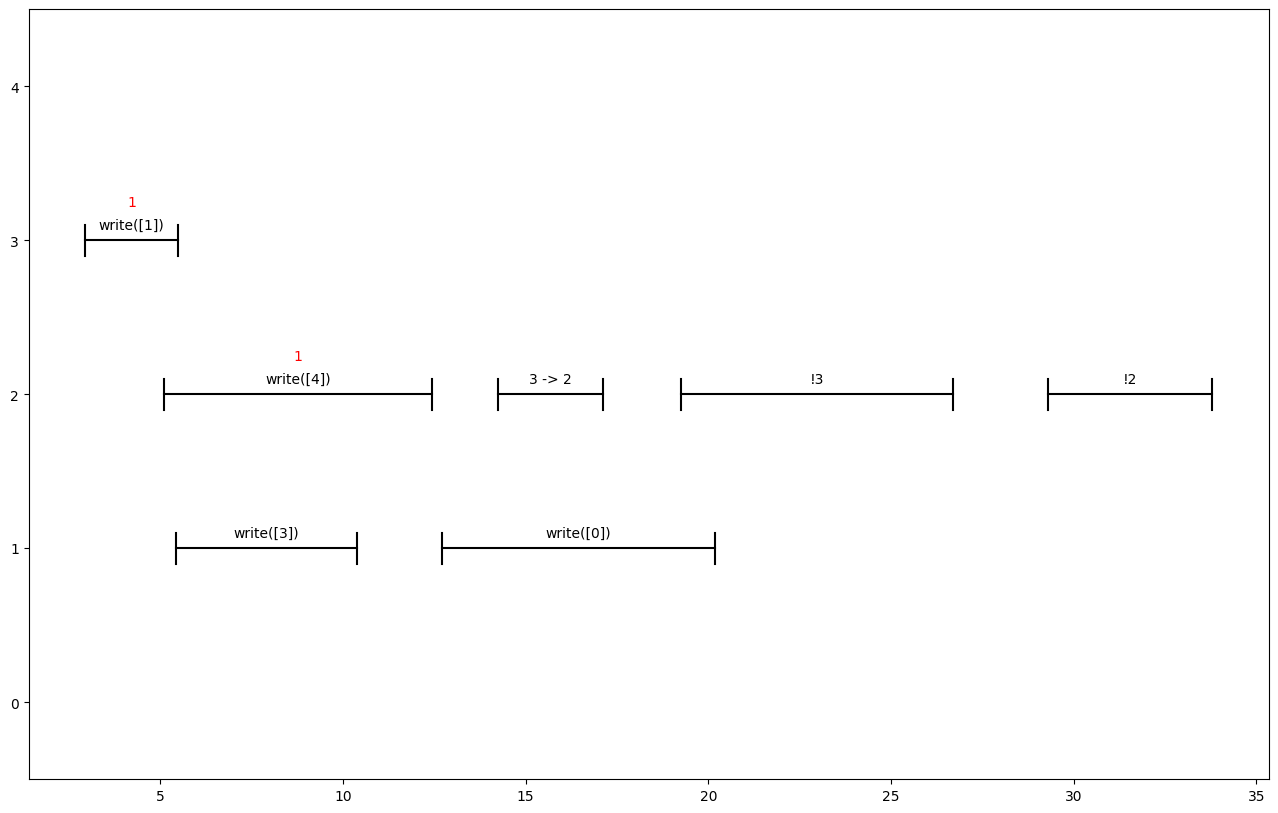

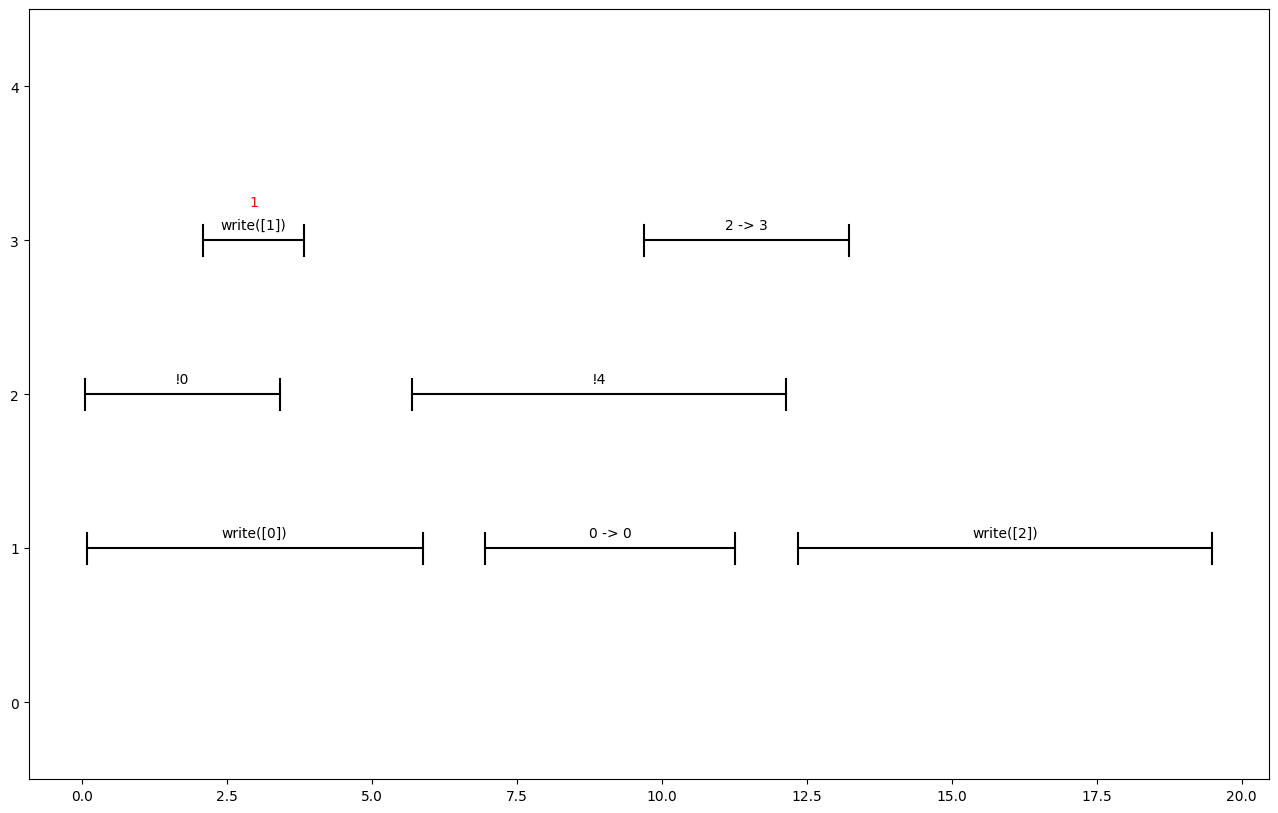

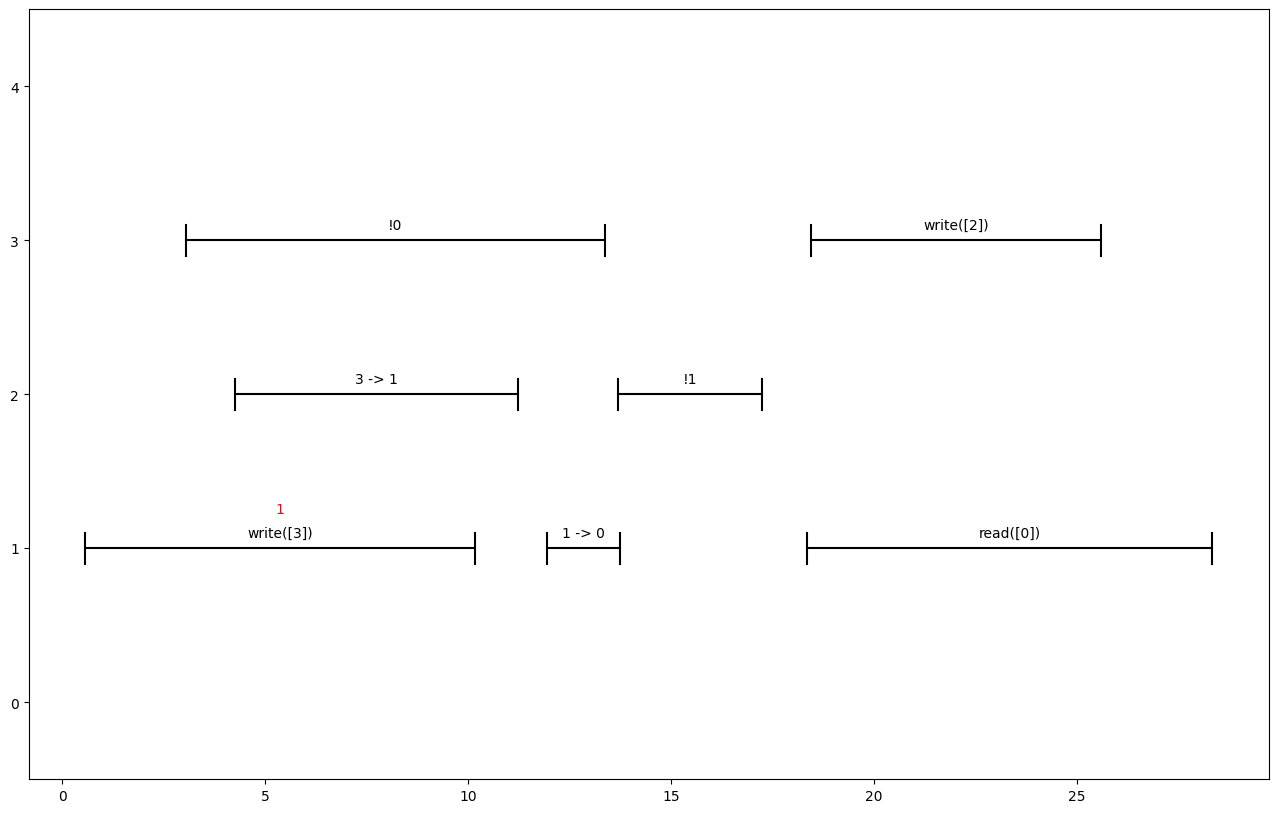

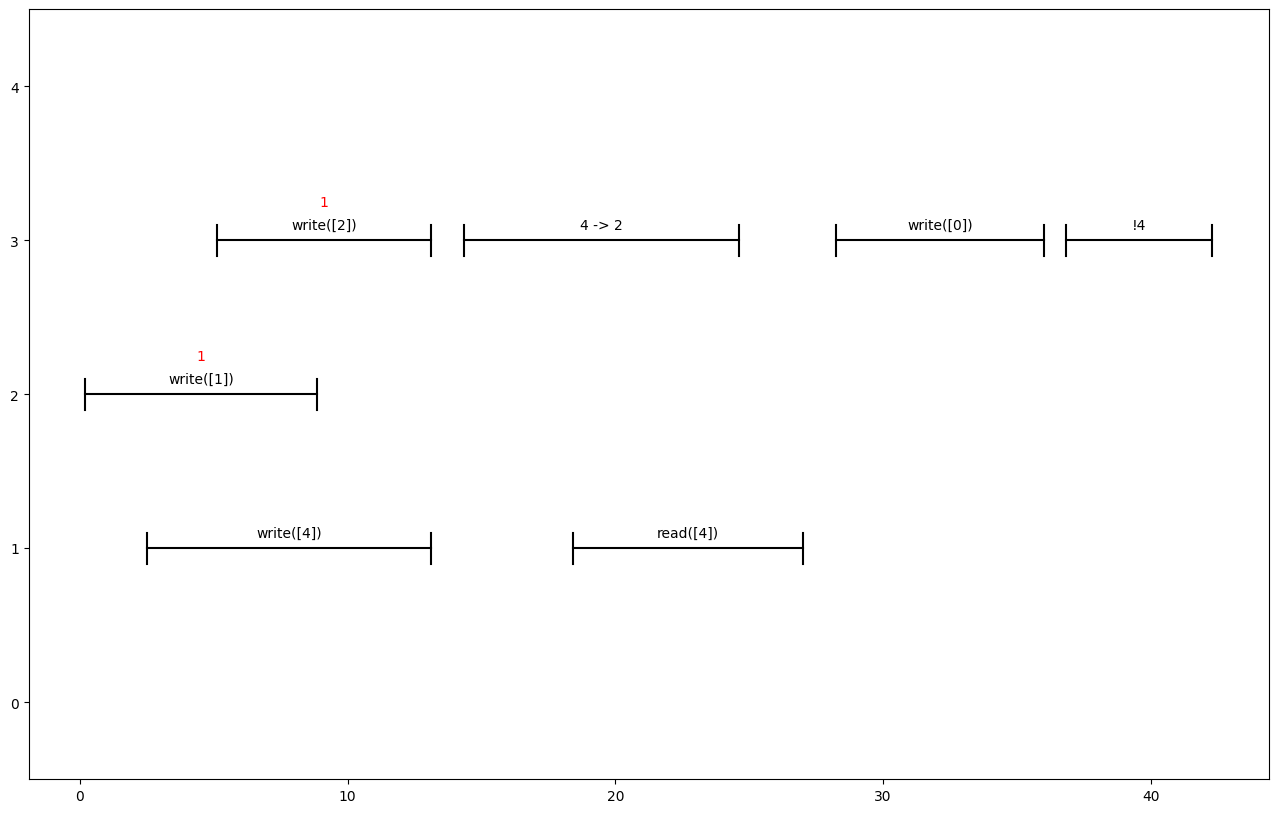

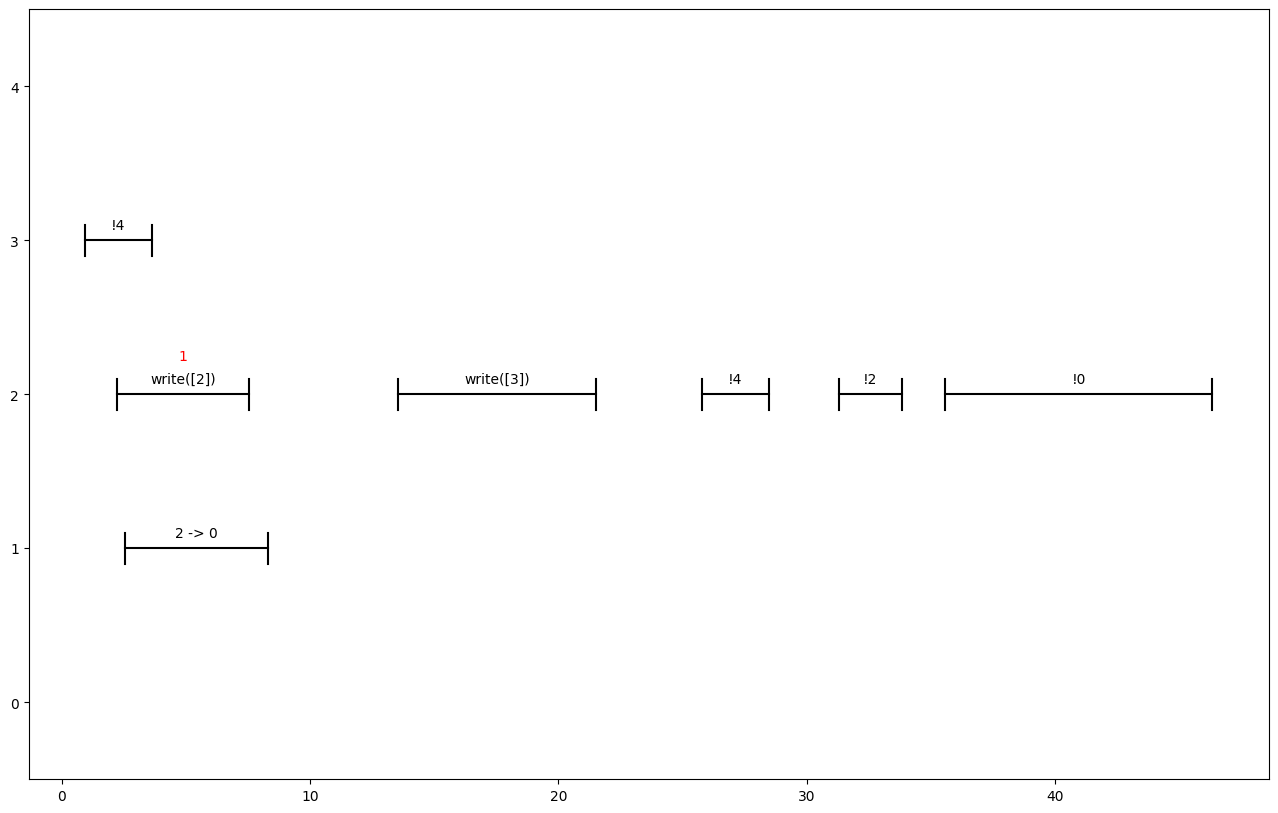

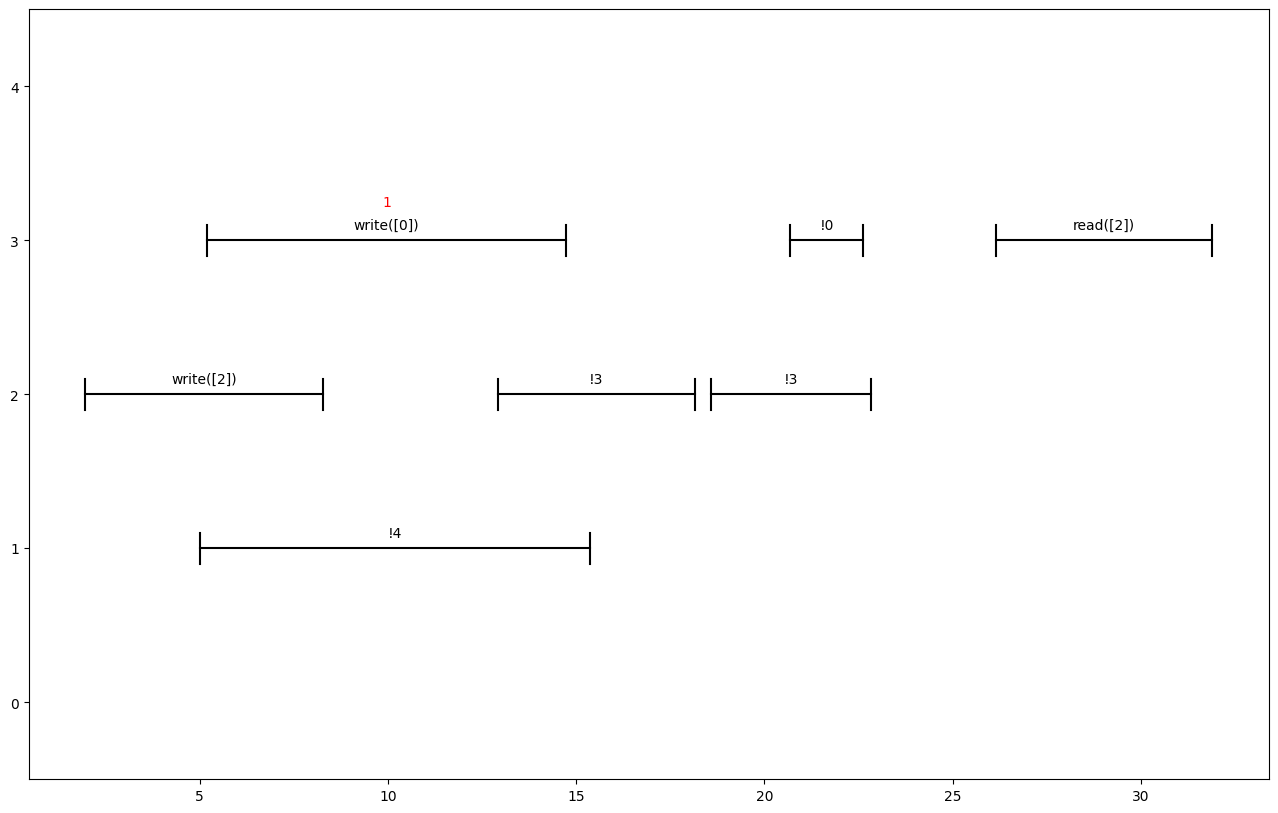

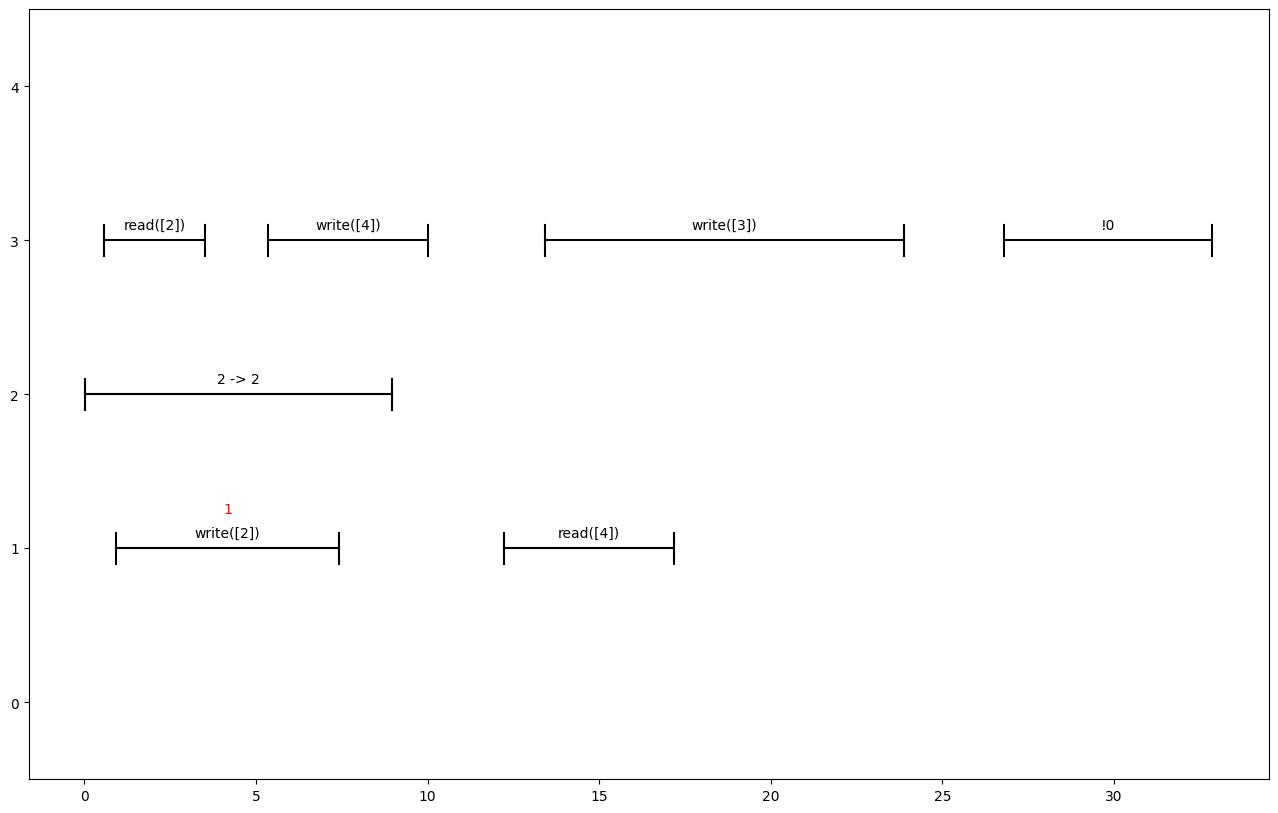

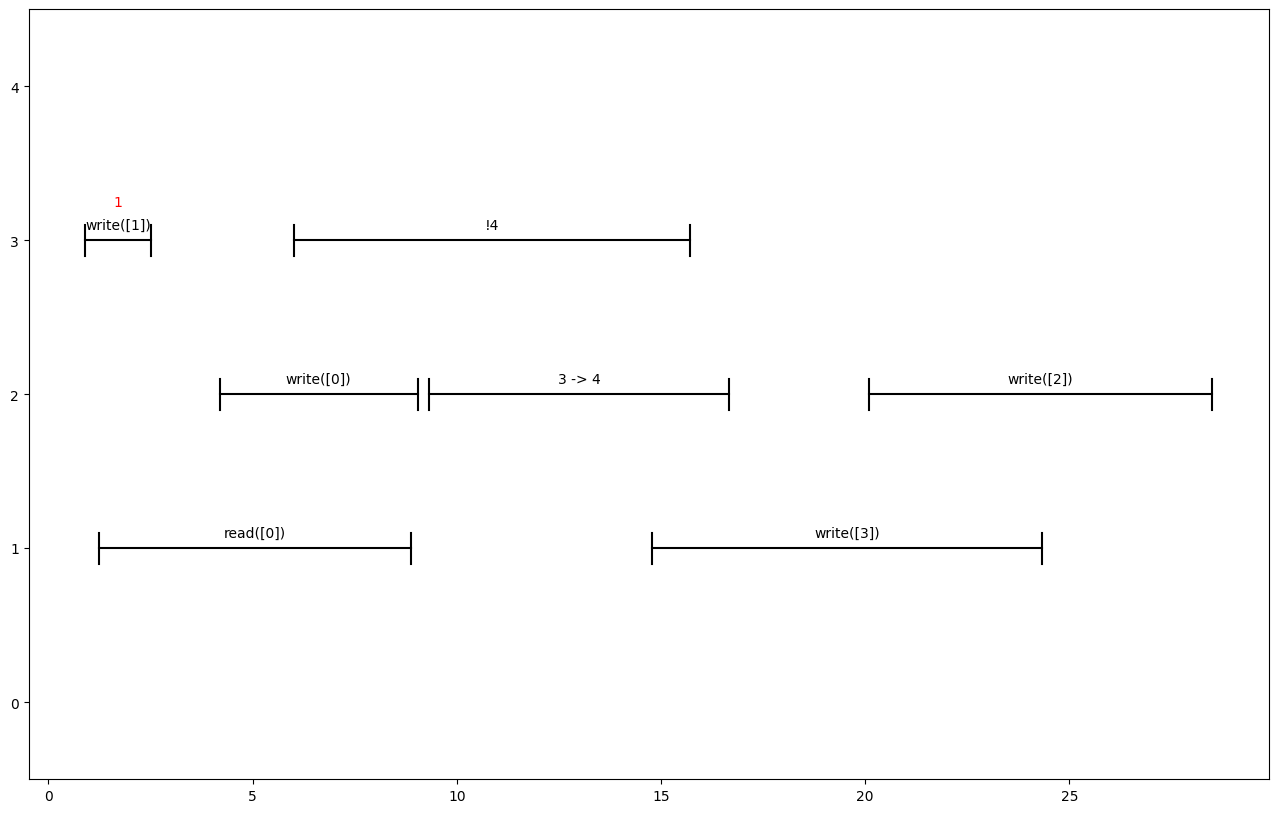

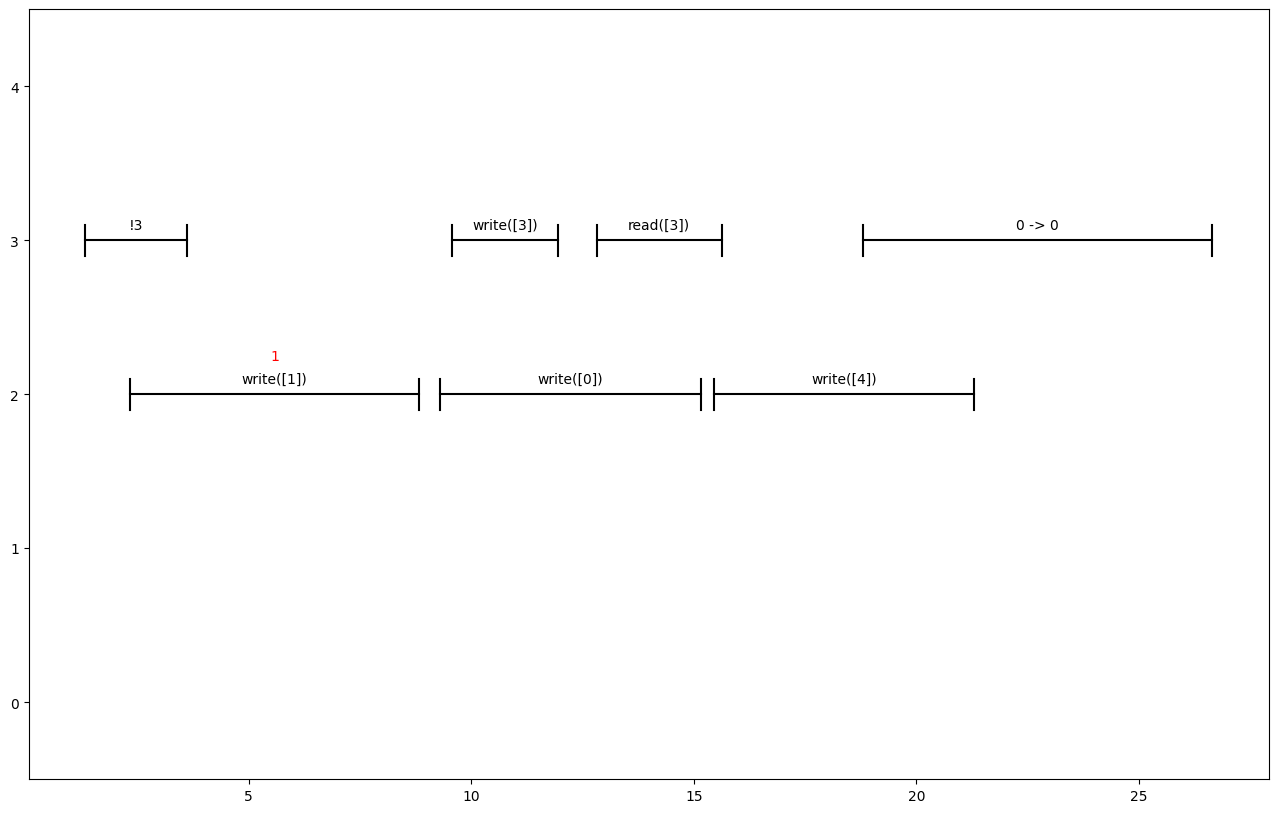

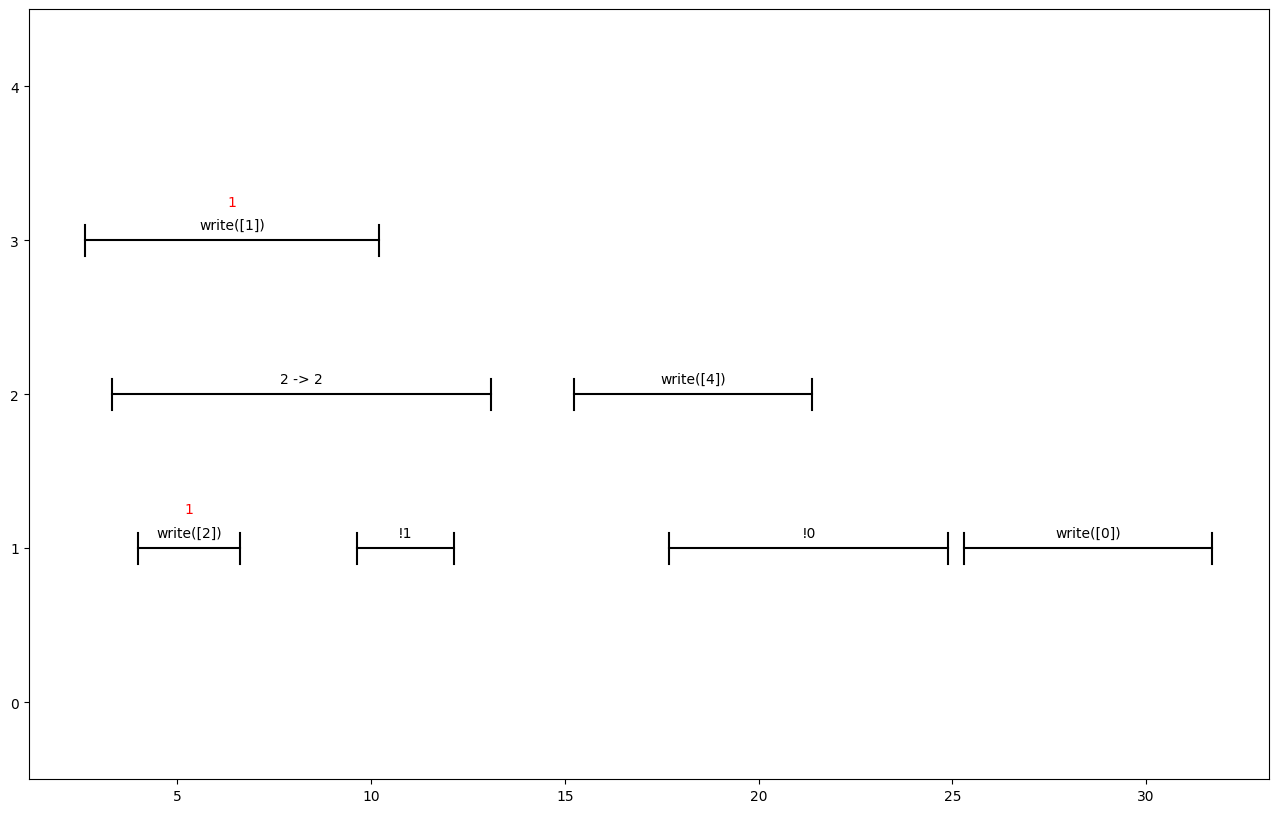

In [ ]:
for hist in testcas[:10]:
    visualize_history(hist)

[[Call(3, write, [1], 4.477758081905306, 13.911600960059854), Call(1, write, [3], 5.732689897257585, 15.450662480995524), Call(2, read, [3], 0.5858646375150308, 10.636908304840656), Call(3, read, [3], 14.000595979902302, 19.139007978651094), Call(2, write, [0], 15.811342666200154, 22.801796414269766), Call(1, cas, [0, 2, False], 21.439703256005213, 31.295495016212822), Call(1, cas, [0, 1, False], 35.03029956387152, 45.19656224509069)]]


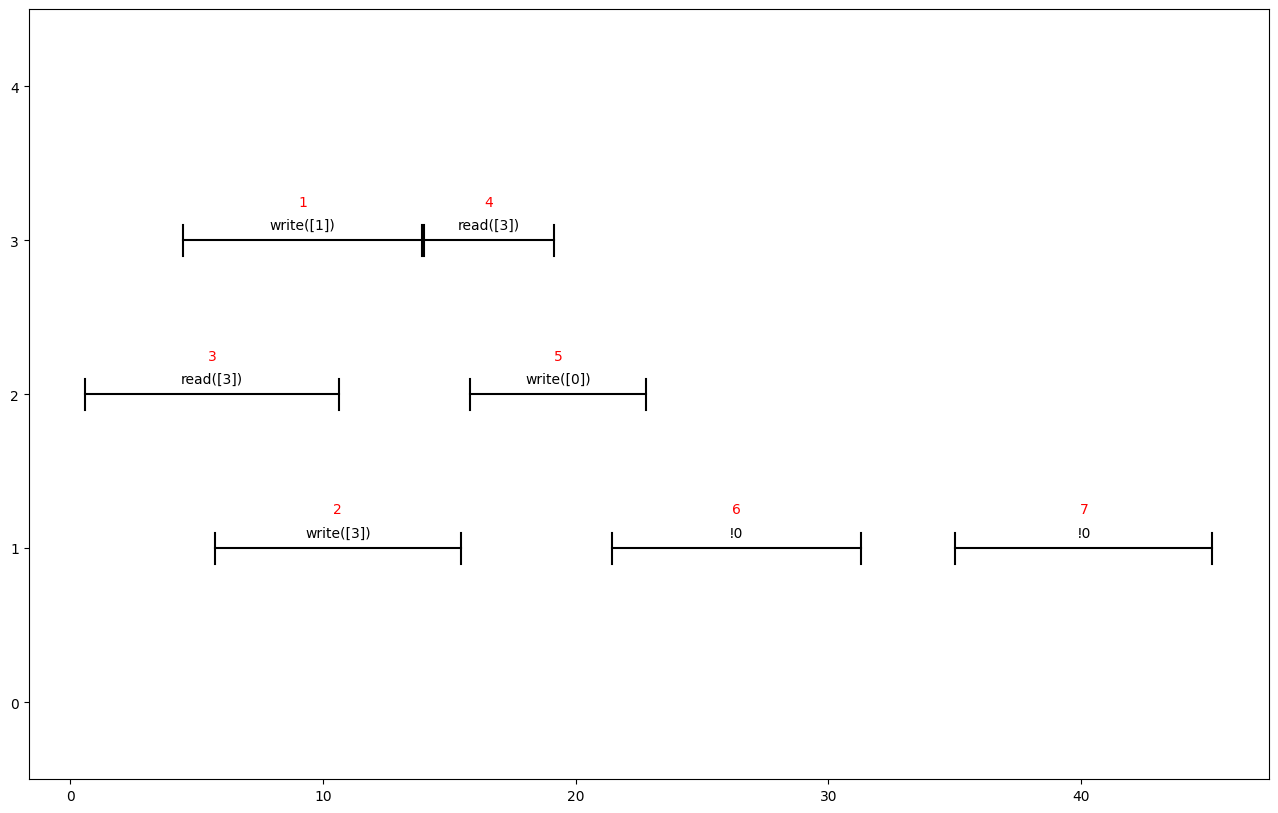

In [109]:
sol = linearize_generic(testcas[4], StateIO())
print(sol)
visualize_history(sol[0])

In [ ]:
i = 0
test_case = copy.deepcopy(testio[i])
sol = linearize_generic(test_case, StateIO())
soltest = linearize_io(test_case)
visualize_history(test_case)

In [ ]:
k = defaultdict(lambda: False)